In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [58]:
import torch
from torchvision import models
import torch.nn as nn
from torch.nn.functional import relu
import matplotlib.pyplot as plt
import numpy as np
import random
from functools import reduce
import itertools
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
from pathlib import Path
import glob
import cv2
import itertools
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import warnings 
warnings.filterwarnings("ignore")
print("DONE")

DONE


In [59]:
class UNet(nn.Module):
    def __init__(self, n_classes):  # Fixed __init__ method
        super(UNet, self).__init__()  # Fixed __init__ method
        
        #ENCODE PART
        ## input = 572, 572,3
        self.el1 = nn.Conv2d(3, 64, 3, padding=1) ## 570,570,64
        self.el2 = nn.Conv2d(64, 64, 3, padding=1) # 568, 568, 64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 284, 284, 64
        
        self.el3 = nn.Conv2d(64, 128, 3, padding=1) #282, 282, 128
        self.el4 = nn.Conv2d(128, 128, 3, padding=1) #280, 280, 128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 140, 140, 128
        
        self.el5 = nn.Conv2d(128, 256, 3, padding=1) #138, 138, 256
        self.el6 = nn.Conv2d(256, 256, 3, padding=1) #136, 136, 256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 68, 68, 256
        
        self.el7 = nn.Conv2d(256, 512, 3, padding=1) #66, 66, 512
        self.el8 = nn.Conv2d(512, 512, 3, padding=1) #64, 64, 512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 32, 32, 512
        
        self.el9 = nn.Conv2d(512, 1024, 3, padding=1) #30, 30, 1024
        self.el10 = nn.Conv2d(1024, 1024, 3, padding=1) #28, 28, 1024
        
        #DECODER PART
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2) # 56, 56, 512
        self.dl1 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dl2 = nn.Conv2d(512, 512, 3, padding=1)
        
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2) # 104, 104, 256
        self.dl3 = nn.Conv2d(512, 256, 3, padding=1)
        self.dl4 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2) # 200,200, 128
        self.dl5 = nn.Conv2d(256, 128, 3, padding=1)
        self.dl6 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2) # 392,392,64
        self.dl7 = nn.Conv2d(128, 64, 3, padding=1)
        self.dl8 = nn.Conv2d(64, 64, 3, padding=1)
        
        #OutputLayer
        self.out = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        #ENCODE PART
        xe11 = relu(self.el1(x))
        xe12 = relu(self.el2(xe11))
        pool1 = self.pool1(xe12)
        
        xe21 = relu(self.el3(pool1))
        xe22 = relu(self.el4(xe21))
        pool2 = self.pool2(xe22)
        
        xe31 = relu(self.el5(pool2))
        xe32 = relu(self.el6(xe31))
        pool3 = self.pool3(xe32)
        
        xe41 = relu(self.el7(pool3))
        xe42 = relu(self.el8(xe41))
        pool4 = self.pool4(xe42)
        
        xe51 = relu(self.el9(pool4))
        xe52 = relu(self.el10(xe51))
        
        #DECODER PART
        xu1 = self.up1(xe52)
        xu1 = torch.cat((xu1, xe42), dim=1) #skip connection
        xu11 = relu(self.dl1(xu1))
        xu12 = relu(self.dl2(xu11))
        
        xu2 = self.up2(xu12)
        xu2 = torch.cat((xu2, xe32), dim=1) #skip connection
        xu21 = relu(self.dl3(xu2))
        xu22 = relu(self.dl4(xu21))
        
        xu3 = self.up3(xu22)
        xu3 = torch.cat((xu3, xe22), dim=1) #skip connection
        xu31 = relu(self.dl5(xu3))
        xu32 = relu(self.dl6(xu31))
        
        xu4 = self.up4(xu32)
        xu4 = torch.cat((xu4, xe12), dim=1) #skip connection
        xu41 = relu(self.dl7(xu4))
        xu42 = relu(self.dl8(xu41))
        
        out = self.out(xu42)
        return out


In [60]:
from pathlib import Path
dataset_path = Path("/kaggle/input/lgg-mri-segmentation")
image_size = 128

In [61]:
image_paths = []
mask_paths = []
# Fixed the glob pattern - removed extra /
for image_path in glob.glob(f"{dataset_path}/**/*.tif", recursive=True):
    if not image_path.endswith("_mask.tif"):  
        mask_path = image_path.replace(".tif", "_mask.tif")
        if os.path.isfile(mask_path): 
            image_paths.append(image_path)
            mask_paths.append(mask_path)

df = pd.DataFrame({"image": image_paths, "mask": mask_paths})
print(f"Count of images: {len(image_paths)}")
print(f"Count of masks: {len(mask_paths)}")

Count of images: 7858
Count of masks: 7858


In [62]:
class BrainMRIDataset(Dataset):
    def __init__(self, df, image_size=128, transform=None):  # Fixed __init__
        self.df = df
        self.image_size = image_size 
        self.transform = transform
        
    def __len__(self):  # Fixed __len__
        return len(self.df)
        
    def __getitem__(self, idx):  # Fixed __getitem__
        img_path = self.df.iloc[idx]['image']
        mask_path = self.df.iloc[idx]['mask']
        
        #READ Image, Mask
        img = cv2.imread(img_path)  # BGR
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if images loaded properly
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        #Resize
        img = cv2.resize(img, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        
        #Normalize
        img = img / 255.0
        # Binary threshold for mask - this is crucial!
        mask = (mask > 0).astype(np.float32)  # Convert to binary 0 or 1
        
        # PyTorch needs the channels first
        img = np.transpose(img, (2, 0, 1))   # (3, H, W)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        
        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        return img, mask




In [63]:
dataset = BrainMRIDataset(df, image_size=image_size)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True) 


In [64]:
for imgs, masks in dataloader:
    print("Images batch:", imgs.shape)  # (B, 3, H, W)
    print("Masks batch:", masks.shape)  # (B, 1, H, W)
    print("Mask value range:", masks.min().item(), "to", masks.max().item())
    print("Mask unique values:", torch.unique(masks))
    break

Images batch: torch.Size([8, 3, 128, 128])
Masks batch: torch.Size([8, 1, 128, 128])
Mask value range: 0.0 to 0.0
Mask unique values: tensor([0.])


In [65]:
dataset_size = len(dataset)
val_size = int(0.3 * dataset_size)
train_size = dataset_size - val_size
generator = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))


Train size: 5501
Val size: 2357


In [66]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)   # convert logits → probabilities
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Calculate class weights for imbalanced dataset
def calculate_class_weights(loader):
    total_pixels = 0
    positive_pixels = 0
    
    for _, masks in loader:
        total_pixels += masks.numel()
        positive_pixels += masks.sum().item()
    
    if positive_pixels == 0:
        return torch.tensor([1.0])
    
    pos_weight = (total_pixels - positive_pixels) / positive_pixels
    return torch.tensor([pos_weight])

# Calculate weights from training data
pos_weight = calculate_class_weights(train_loader)
print(f"Positive class weight: {pos_weight.item():.2f}")

# Use weighted BCE loss
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))


def combined_loss(outputs, targets):
    bce_loss = bce(outputs, targets)
    d_loss = dice_loss(outputs, targets)
    return 0.7 * bce_loss + 0.3 * d_loss  # Weight the losses


Positive class weight: 91.38


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [68]:
model = UNet(n_classes=1).to(device)
# Lower learning rate and add weight decay
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5) 


In [69]:
def train_one_epoch(loader, model, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)  # (B,1,H,W)

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        
        # compute accuracy (threshold at 0.5)
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == masks.bool()).sum().item()
        total += masks.numel()

    return running_loss / len(loader.dataset), correct / total


In [70]:
def validate(loader, model, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            loss = combined_loss(outputs, masks)
            running_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == masks.bool()).sum().item()
            total += masks.numel()

    return running_loss / len(loader.dataset), correct / total


In [71]:
best_val_loss = float("inf")
num_epochs = 30  

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(train_loader, model, criterion, optimizer, device)
    val_loss, val_acc = validate(val_loader, model, criterion, device)
    
    # Step the scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "
          f"LR: {current_lr:.2e}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("✓ Saved best model")
    
    # Early stopping
    if current_lr < 1e-6:
        print("Learning rate too small, stopping...")
        break 

Epoch 1/30 Train Loss: 0.6331, Train Acc: 0.8552 Val Loss: 0.5204, Val Acc: 0.9001 LR: 5.00e-04
✓ Saved best model
Epoch 2/30 Train Loss: 0.5352, Train Acc: 0.9039 Val Loss: 0.4673, Val Acc: 0.9226 LR: 5.00e-04
✓ Saved best model
Epoch 3/30 Train Loss: 0.4762, Train Acc: 0.9238 Val Loss: 0.4417, Val Acc: 0.9492 LR: 5.00e-04
✓ Saved best model
Epoch 4/30 Train Loss: 0.4592, Train Acc: 0.9258 Val Loss: 0.4189, Val Acc: 0.9536 LR: 5.00e-04
✓ Saved best model
Epoch 5/30 Train Loss: 0.4596, Train Acc: 0.9282 Val Loss: 0.4484, Val Acc: 0.9399 LR: 5.00e-04
Epoch 6/30 Train Loss: 0.4801, Train Acc: 0.9193 Val Loss: 0.4745, Val Acc: 0.9397 LR: 5.00e-04
Epoch 7/30 Train Loss: 0.4733, Train Acc: 0.9217 Val Loss: 0.4249, Val Acc: 0.9309 LR: 5.00e-04
Epoch 8/30 Train Loss: 0.4545, Train Acc: 0.9309 Val Loss: 0.4216, Val Acc: 0.9437 LR: 2.50e-04
Epoch 9/30 Train Loss: 0.4307, Train Acc: 0.9378 Val Loss: 0.4467, Val Acc: 0.9343 LR: 2.50e-04
Epoch 10/30 Train Loss: 0.4120, Train Acc: 0.9440 Val Loss: 

In [72]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth) 

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model properly on device
loaded_model = UNet(n_classes=1)
loaded_model.load_state_dict(torch.load("best_model.pth", map_location=device))
loaded_model = loaded_model.to(device)  
loaded_model.eval()

# Loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [73]:
#  Run validation
val_loss, val_acc = validate(val_loader, loaded_model, criterion, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.1923
Validation Accuracy: 0.9857


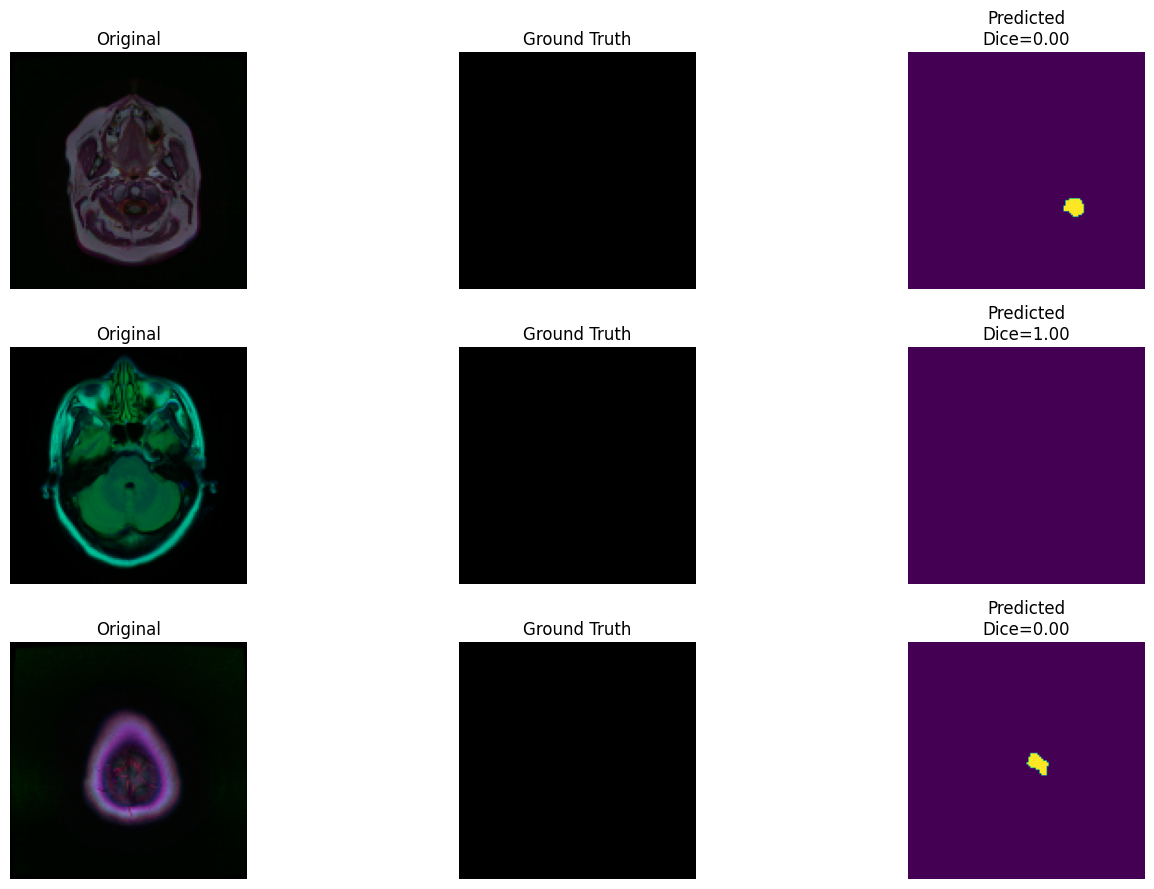

In [74]:
num_examples = 3  # Show more examples
plt.figure(figsize=(15, num_examples * 3))

loaded_model.eval()
with torch.no_grad():
    for i in range(num_examples):
        idx = random.randint(0, len(val_ds) - 1)  # random sample
        img, true_mask = val_ds[idx]
        
        # Add batch dimension + send to device
        input_img = img.unsqueeze(0).to(device)  # [1, C, H, W]
        output = loaded_model(input_img)

        # Apply sigmoid and threshold - try different thresholds
        pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()
        
        # Try adaptive thresholding based on prediction statistics
        threshold = 0.5
        if pred_mask.max() > 0.8:  # If model is very confident
            threshold = 0.7
        elif pred_mask.max() < 0.3:  # If model is not confident
            threshold = 0.2
            
        pred_mask_bin = (pred_mask > threshold).astype(np.float32)
        
        # If still predicting everything, try Otsu's thresholding
        if pred_mask_bin.sum() > 0.8 * pred_mask_bin.size:  # If >80% predicted as positive
            from skimage import filters
            try:
                threshold_otsu = filters.threshold_otsu(pred_mask)
                pred_mask_bin = (pred_mask > threshold_otsu).astype(np.float32)
            except:
                pred_mask_bin = (pred_mask > 0.9).astype(np.float32)  # Very high threshold
        
        # Convert to numpy for visualization
        img_np = img.permute(1, 2, 0).numpy()   # CHW → HWC
        true_mask_np = true_mask.squeeze().numpy()
        
        # Dice score
        dice = dice_coefficient(torch.tensor(true_mask_np), torch.tensor(pred_mask_bin))
        
        # Plot
        plt.subplot(num_examples, 3, i*3 + 1)
        plt.imshow(img_np)
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(num_examples, 3, i*3 + 2)
        plt.imshow(true_mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis('off')
        
        plt.subplot(num_examples, 3, i*3 + 3)
        plt.imshow(pred_mask_bin, cmap="viridis")
        plt.title(f"Predicted\nDice={dice:.2f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

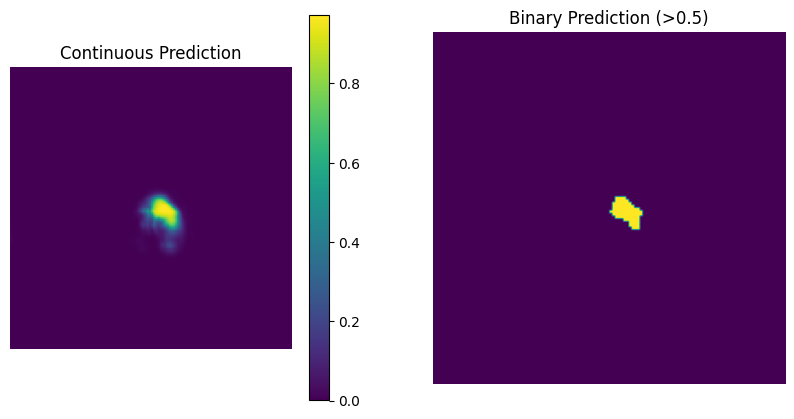

Training completed successfully!


In [75]:
# Show the continuous prediction as well
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_mask, cmap="viridis")
plt.colorbar()
plt.title("Continuous Prediction")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_bin, cmap="viridis")
plt.title("Binary Prediction (>0.5)")
plt.axis('off')
plt.show()

print("Training completed successfully!")

In [76]:
# Check data balance
total_pixels = 0
positive_pixels = 0
for _, masks in train_loader:
    total_pixels += masks.numel()
    positive_pixels += masks.sum().item()
    
print(f"Positive pixels: {positive_pixels/total_pixels*100:.2f}%")
print(f"Negative pixels: {(total_pixels-positive_pixels)/total_pixels*100:.2f}%")

Positive pixels: 1.08%
Negative pixels: 98.92%
